In [5]:
import pickle

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import seaborn as sns

from core.src.constants import IMAGES_PATH, TRAIN_DATA_CSV, TEST_DATA_CSV, FINE_TUNED_FASTVIT_MODEL_PATH, TARGET_SCALER_PATH, MODELS_PATH
from PIL import Image
import timm
from torch import nn
import pandas as pd

from core.src.utils.metrics import compute_metrics
from core.src.utils.plots import plot_loss_and_metrics, print_metrics_table

with open(TARGET_SCALER_PATH, "rb") as f:
    target_scaler = pickle.load(f)

model = timm.create_model("fastvit_t8.apple_in1k", pretrained=True, num_classes=0)

model.head = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(model.num_features, 1))

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=True)

model

FastVit(
  (stem): Sequential(
    (0): MobileOneBlock(
      (se): Identity()
      (conv_kxk): ModuleList(
        (0): ConvNormAct(
          (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNormAct2d(
            48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): Identity()
          )
        )
      )
      (conv_scale): ConvNormAct(
        (conv): Conv2d(3, 48, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (bn): BatchNormAct2d(
          48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
      )
      (act): GELU(approximate='none')
    )
    (1): MobileOneBlock(
      (se): Identity()
      (conv_kxk): ModuleList(
        (0): ConvNormAct(
          (conv): Conv2d(48, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=48, bias=False)
          (bn): Batch

In [6]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, prices, transform=None):
        self.image_paths = image_paths
        self.prices = prices
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx])
        price = self.prices[idx]
        if self.transform:
            img = self.transform(img)
        return img, price


SLICE: int | None = None

df_train = pd.read_csv(TRAIN_DATA_CSV, dtype={"id": str})[:SLICE]
df_test = pd.read_csv(TEST_DATA_CSV, dtype={"id": str})[:SLICE]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_images = df_train["id"].values
train_images = [IMAGES_PATH / f"{path}.png" for path in train_images]

test_images = df_test["id"].values
test_images = [IMAGES_PATH / f"{path}.png" for path in test_images]

train_dataset = CustomDataset(
    image_paths=train_images,
    prices=df_train["price_std"].values,
    transform=transforms,
)

test_dataset = CustomDataset(
    image_paths=test_images,
    prices=df_test["price_std"].values,
    transform=transforms,
)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

history = {"train_loss": [], "test_loss": []}
metrics_history = {"train_mae": [], "test_mae": [], "train_rmse": [], "test_rmse": [], "train_r2": [], "test_r2": [], "train_mse": [], "test_mse": []}

num_epochs = 15  # or more depending on convergence

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    all_train_predictions = []
    all_train_ground_truths = []
    for images, prices in tqdm(train_loader):
        images = images.to(device)
        prices = prices.to(device)

        # Forward pass
        outputs = model(images).squeeze()  # Squeeze is used to remove extra dim if any at output
        loss = criterion(outputs, prices.float())

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        unnorm_outputs = target_scaler.inverse_transform(outputs.cpu().detach().numpy().reshape(-1, 1)).reshape(-1)
        unnorm_prices = target_scaler.inverse_transform(prices.cpu().detach().numpy().reshape(-1, 1)).reshape(-1)

        all_train_predictions.extend(unnorm_outputs.tolist())
        all_train_ground_truths.extend(unnorm_prices.tolist())

    train_metrics = compute_metrics(all_train_predictions, all_train_ground_truths)
    metrics_history["train_mae"].append(train_metrics["MAE"])
    metrics_history["train_mse"].append(train_metrics["MSE"])
    metrics_history["train_rmse"].append(train_metrics["RMSE"])
    metrics_history["train_r2"].append(train_metrics["R2"])

    avg_train_loss = np.sum(train_losses) / len(train_loader)
    history["train_loss"].append(avg_train_loss)
    print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss}")
    print(f"Epoch {epoch + 1}, Train Metrics: {train_metrics}")

    model.eval()
    with torch.no_grad():
        validation_losses = []
        all_test_predictions = []
        all_test_ground_truths = []
        for images, prices in test_loader:
            images = images.to(device)
            prices = prices.to(device)

            # Forward pass
            outputs = model(images).squeeze()  # Squeeze is used to remove extra dim if any at output
            val_loss = criterion(outputs, prices.float())

            validation_losses.append(val_loss.item())

            unnorm_outputs = target_scaler.inverse_transform(outputs.cpu().detach().numpy().reshape(-1, 1)).reshape(-1)
            unnorm_prices = target_scaler.inverse_transform(prices.cpu().detach().numpy().reshape(-1, 1)).reshape(-1)

            all_test_predictions.extend(unnorm_outputs.tolist())
            all_test_ground_truths.extend(unnorm_prices.tolist())

        avg_val_loss = np.sum(validation_losses) / len(test_loader)
        history["test_loss"].append(avg_val_loss)

        test_metrics = compute_metrics(all_test_predictions, all_test_ground_truths)
        metrics_history["test_mae"].append(test_metrics["MAE"])
        metrics_history["test_mse"].append(test_metrics["MSE"])
        metrics_history["test_rmse"].append(test_metrics["RMSE"])
        metrics_history["test_r2"].append(test_metrics["R2"])

        print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss}")
        print(f"Epoch {epoch + 1}, Test Metrics: {test_metrics}")

    torch.save(model.state_dict(), MODELS_PATH / f"fine_tuned_fastvit_model_{epoch+1}.pth")

100%|██████████| 538/538 [03:05<00:00,  2.90it/s]


Epoch 1, Train Loss: 0.8924291722171812
Epoch 1, Train Metrics: {'MAE': 6631.977337277434, 'MSE': 70585997.25047934, 'RMSE': 8401.547312875131, 'R2': 0.10937620998378461}
Epoch 1, Validation Loss: 1.47973332118105
Epoch 1, Test Metrics: {'MAE': 6351.4107002009905, 'MSE': 117280771.44222337, 'RMSE': 10829.62471382196, 'R2': -0.4979399182560673}


100%|██████████| 538/538 [03:04<00:00,  2.91it/s]


Epoch 2, Train Loss: 0.6787955652382294
Epoch 2, Train Metrics: {'MAE': 5644.083350917018, 'MSE': 53657895.43206935, 'RMSE': 7325.154976658811, 'R2': 0.3229677265248406}
Epoch 2, Validation Loss: 0.6133265237013499
Epoch 2, Test Metrics: {'MAE': 5314.030673555773, 'MSE': 48377534.326269776, 'RMSE': 6955.396058188906, 'R2': 0.38210979580892124}


100%|██████████| 538/538 [03:06<00:00,  2.89it/s]


Epoch 3, Train Loss: 0.5994851168757478
Epoch 3, Train Metrics: {'MAE': 5262.12116379006, 'MSE': 47404442.496369116, 'RMSE': 6885.088416016828, 'R2': 0.401871109224354}
Epoch 3, Validation Loss: 0.5508767009885223
Epoch 3, Test Metrics: {'MAE': 4926.498623004292, 'MSE': 43430188.020788684, 'RMSE': 6590.158421524378, 'R2': 0.44529856434518233}


100%|██████████| 538/538 [03:04<00:00,  2.92it/s]


Epoch 4, Train Loss: 0.5404299712535617
Epoch 4, Train Metrics: {'MAE': 4926.132373444313, 'MSE': 42758177.45409386, 'RMSE': 6538.973730953036, 'R2': 0.4604956855222109}
Epoch 4, Validation Loss: 0.5556135934812051
Epoch 4, Test Metrics: {'MAE': 4735.103136539015, 'MSE': 43716167.84539182, 'RMSE': 6611.820312545692, 'R2': 0.4416459571034238}


100%|██████████| 538/538 [03:04<00:00,  2.91it/s]


Epoch 5, Train Loss: 0.5126463416617599
Epoch 5, Train Metrics: {'MAE': 4756.439166027779, 'MSE': 40550846.75843181, 'RMSE': 6367.954676223113, 'R2': 0.4883468359850077}
Epoch 5, Validation Loss: 0.4962265583100142
Epoch 5, Test Metrics: {'MAE': 4521.465904654569, 'MSE': 39216718.8450902, 'RMSE': 6262.325354458215, 'R2': 0.4991140670487054}


100%|██████████| 538/538 [03:03<00:00,  2.93it/s]


Epoch 6, Train Loss: 0.4840137332013105
Epoch 6, Train Metrics: {'MAE': 4598.234016371661, 'MSE': 38288478.101935625, 'RMSE': 6187.768426657192, 'R2': 0.5168924317936557}
Epoch 6, Validation Loss: 0.45685009603147153
Epoch 6, Test Metrics: {'MAE': 4445.802250607513, 'MSE': 36062288.572140485, 'RMSE': 6005.188470992437, 'R2': 0.5394032548422436}


100%|██████████| 538/538 [03:03<00:00,  2.93it/s]


Epoch 7, Train Loss: 0.4621438456069138
Epoch 7, Train Metrics: {'MAE': 4480.007051341921, 'MSE': 36555380.53546737, 'RMSE': 6046.104575300313, 'R2': 0.5387599123597868}
Epoch 7, Validation Loss: 0.44681651713671505
Epoch 7, Test Metrics: {'MAE': 4351.007742236825, 'MSE': 35282657.42856513, 'RMSE': 5939.92065844024, 'R2': 0.5493609026059478}


100%|██████████| 538/538 [03:03<00:00,  2.93it/s]


Epoch 8, Train Loss: 0.4462117490992227
Epoch 8, Train Metrics: {'MAE': 4390.55111626492, 'MSE': 35310595.97982533, 'RMSE': 5942.271954381197, 'R2': 0.5544660691314407}
Epoch 8, Validation Loss: 0.43340043315181026
Epoch 8, Test Metrics: {'MAE': 4284.888770310158, 'MSE': 34340363.92184879, 'RMSE': 5860.065180682616, 'R2': 0.5613961155489258}


100%|██████████| 538/538 [03:03<00:00,  2.92it/s]


Epoch 9, Train Loss: 0.43517584008853677
Epoch 9, Train Metrics: {'MAE': 4315.389442723518, 'MSE': 34410690.754042685, 'RMSE': 5866.062627865704, 'R2': 0.5658206866768705}
Epoch 9, Validation Loss: 0.4343037955186985
Epoch 9, Test Metrics: {'MAE': 4201.76579311637, 'MSE': 34162225.6955437, 'RMSE': 5844.846079713622, 'R2': 0.5636713423987184}


100%|██████████| 538/538 [03:13<00:00,  2.78it/s]


Epoch 10, Train Loss: 0.4177900084387857
Epoch 10, Train Metrics: {'MAE': 4236.229576836963, 'MSE': 33064026.560798105, 'RMSE': 5750.132742884994, 'R2': 0.5828123169489563}
Epoch 10, Validation Loss: 0.3992127961582608
Epoch 10, Test Metrics: {'MAE': 4094.778478535497, 'MSE': 31589251.175754074, 'RMSE': 5620.43158269488, 'R2': 0.5965340290476318}


100%|██████████| 538/538 [03:22<00:00,  2.66it/s]


Epoch 11, Train Loss: 0.40867720976416505
Epoch 11, Train Metrics: {'MAE': 4182.484860867124, 'MSE': 32342551.50830597, 'RMSE': 5687.051213793135, 'R2': 0.5919155792202608}
Epoch 11, Validation Loss: 0.4044293337398105
Epoch 11, Test Metrics: {'MAE': 4087.8193613025755, 'MSE': 31959757.810862653, 'RMSE': 5653.296189911038, 'R2': 0.5918018238286262}


100%|██████████| 538/538 [03:27<00:00,  2.60it/s]


Epoch 12, Train Loss: 0.39252867821091614
Epoch 12, Train Metrics: {'MAE': 4093.231429418076, 'MSE': 31054148.38974591, 'RMSE': 5572.6249101968015, 'R2': 0.6081720962805603}
Epoch 12, Validation Loss: 0.38907412820392184
Epoch 12, Test Metrics: {'MAE': 4045.474162583462, 'MSE': 30796297.48109076, 'RMSE': 5549.441186380009, 'R2': 0.6066618358309455}


100%|██████████| 538/538 [03:17<00:00,  2.73it/s]


Epoch 13, Train Loss: 0.3819485045277053
Epoch 13, Train Metrics: {'MAE': 4032.36158097622, 'MSE': 30208824.386654932, 'RMSE': 5496.2554877529965, 'R2': 0.6188380314058086}
Epoch 13, Validation Loss: 0.38882649849962303
Epoch 13, Test Metrics: {'MAE': 4066.9305602574905, 'MSE': 30727431.346104413, 'RMSE': 5543.232932694098, 'R2': 0.6075414116671505}


100%|██████████| 538/538 [03:38<00:00,  2.46it/s]


Epoch 14, Train Loss: 0.37730378771138456
Epoch 14, Train Metrics: {'MAE': 4000.9910199892797, 'MSE': 29861087.174119238, 'RMSE': 5464.529913370338, 'R2': 0.6232256301679144}
Epoch 14, Validation Loss: 0.3769554980375149
Epoch 14, Test Metrics: {'MAE': 3984.427026338799, 'MSE': 29869700.80870179, 'RMSE': 5465.317997033822, 'R2': 0.6184965648033622}


100%|██████████| 538/538 [03:43<00:00,  2.41it/s]


Epoch 15, Train Loss: 0.36410202311705037
Epoch 15, Train Metrics: {'MAE': 3912.7920307625172, 'MSE': 28780832.05920443, 'RMSE': 5364.776981311006, 'R2': 0.6368558251372616}
Epoch 15, Validation Loss: 0.37494039303726623
Epoch 15, Test Metrics: {'MAE': 3938.6015739405434, 'MSE': 29660459.66678673, 'RMSE': 5446.141722980291, 'R2': 0.6211690460222503}


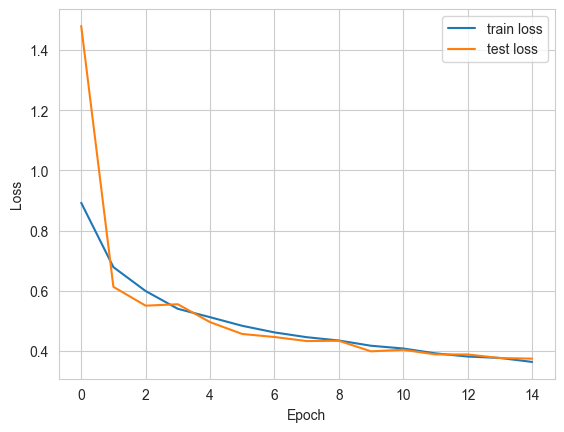

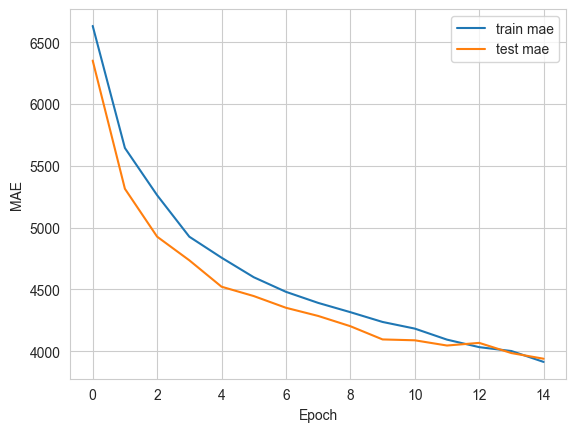

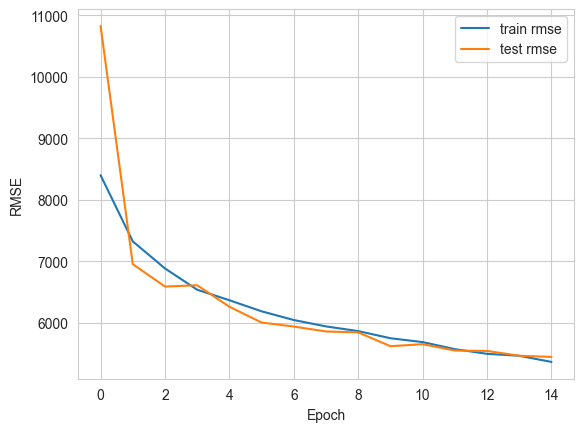

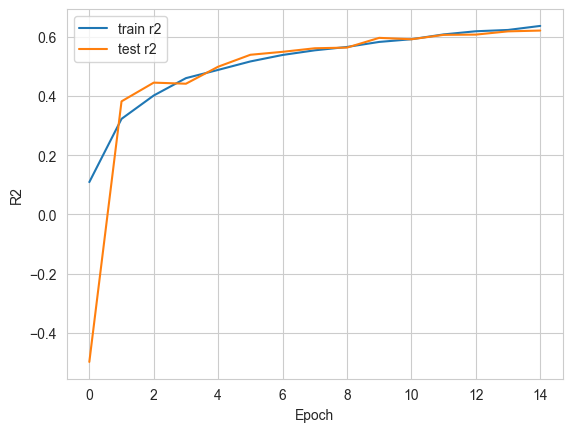

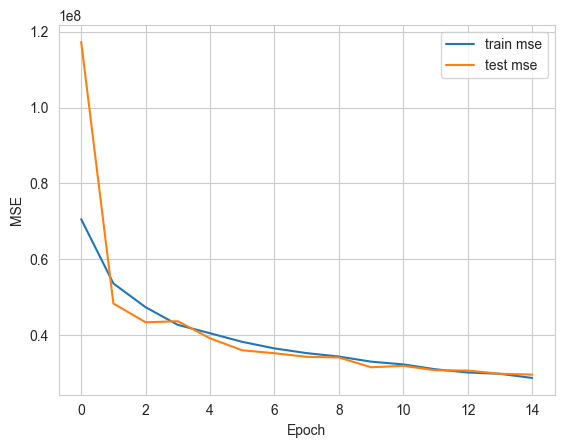

Train Metrics
+---------+---------+---------+---------+-------------+
|   Epoch |     MAE |    RMSE |      R2 |         MSE |
+=========+=========+=========+=========+=============+
|      14 | 3912.79 | 5364.78 | 0.63686 | 2.87808e+07 |
+---------+---------+---------+---------+-------------+

Test Metrics
+---------+--------+---------+---------+-------------+
|   Epoch |    MAE |    RMSE |      R2 |         MSE |
+=========+========+=========+=========+=============+
|      14 | 3938.6 | 5446.14 | 0.62117 | 2.96605e+07 |
+---------+--------+---------+---------+-------------+


In [9]:
plot_loss_and_metrics(history, metrics_history, SLICE_START=0)
print_metrics_table(metrics_history)

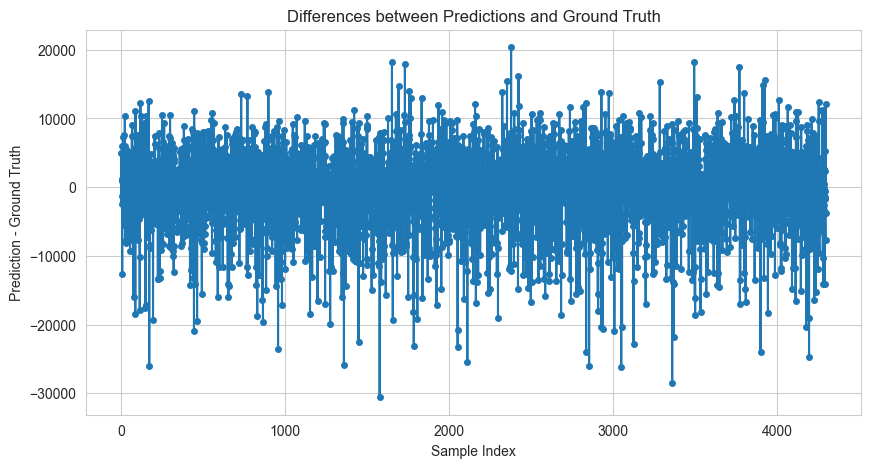

Average absolute difference: 3940.27


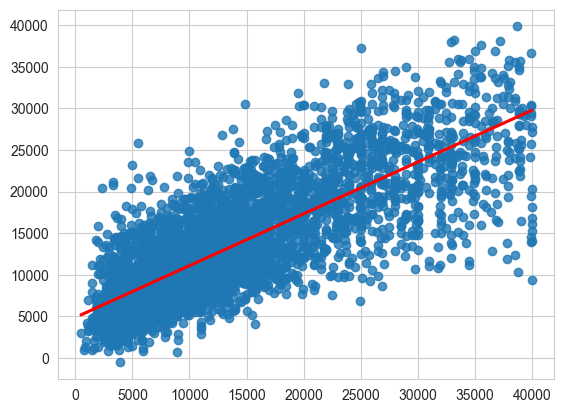

In [10]:
differences = []
abs_differences = []
gt = []
pred = []

with torch.no_grad():
    for images, prices in test_loader:
        images = images.to(device)
        prices = prices.to(device)
        outputs = model(images).squeeze()

        prices = prices.cpu().numpy()
        outputs = outputs.cpu().numpy()

        unnorm_outputs = target_scaler.inverse_transform(outputs.reshape(-1, 1)).reshape(-1)
        unnorm_prices = target_scaler.inverse_transform(prices.reshape(-1, 1)).reshape(-1)

        for output, target in zip(unnorm_outputs, unnorm_prices):
            diff = output - target
            differences.append(diff)
            abs_differences.append(abs(diff))
            gt.append(target)
            pred.append(output)

# Plotting the differences
plt.figure(figsize=(10, 5))
plt.plot(differences, marker="o", linestyle="-", markersize=4)
plt.title("Differences between Predictions and Ground Truth")
plt.xlabel("Sample Index")
plt.ylabel("Prediction - Ground Truth")
plt.grid(True)
plt.show()

sns.regplot(x=gt, y=pred, ci=None, scatter=True, line_kws={"color": "red"})

# calculate the average difference
average_abs_diff = sum(abs_differences) / len(abs_differences)
print(f"Average absolute difference: {average_abs_diff:.2f}")

In [11]:
# torch.save(model.state_dict(), f=FINE_TUNED_FASTVIT_MODEL_PATH)

# Inference example

In [12]:
# model = timm.create_model("fastvit_t8.apple_in1k", pretrained=True, num_classes=0)
#
# model.head = nn.Sequential(
#     nn.AdaptiveAvgPool2d(1),
#     nn.Flatten(),
#     nn.Linear(model.num_features, 1)
# )
#
# model.load_state_dict(torch.load(FINE_TUNED_FASTVIT_MODEL_PATH))
# model.to(device)
#
# model
#
#
# class FastViTEmbedding(nn.Module):
#     def __init__(self, model):
#         super(FastViTEmbedding, self).__init__()
#         self.model = model
#         self.pool = nn.AdaptiveAvgPool2d(1)
#
#     def forward(self, x):
#         # Assuming the embeddings you want are just before the head.
#         # This accesses the last layer before the regression head.
#         x = self.model.forward_features(x)
#         x = self.pool(x)
#         x = x.view(x.size(0), -1)
#         return x
#
#
# embedding_model = FastViTEmbedding(model).to(device)
# embedding_model.eval()
#
# with torch.no_grad():
#     for images, _ in test_loader:  # Ignore prices if you just need embeddings
#         images = images.to(device)
#         embeddings = embedding_model(images)
#         print("Embedding shape:", embeddings.shape)